# Introduction - AdventureWorks2025 Sales Analysis
The purpose behind this analysis is to give concrete information on the products and regions that sell the most and what they sell. With this information, a recommendation to the business of how to proceed is to be given.

## Conclusion
From the analyzed data, bikes sell the most by far. Whereas accesories perform the worst followed by clothing. Bikes has the highest revenue of all ProductCategories and ProductSubcategories

**ProductCategory:**
1. Bikes (1) at 95145813.3519
2. Components (2) at 11807808.0245
3. Clothing (3) at 2141507.0245
4. Accessories (4) at 1278760.9125

**ProductSubcategory:**
1. Road Bikes (2) at 43,978,443.2489
2. Mountain Bikes (1) at 36,622,296.4507
3. Touring Bikes (3) at 14,545,073.6523

**Region:**

* Territory 4 (Southwest, North America) has the highest average order value for both store and individual orders

Based on this information, increase the availability of bikes and make it easier for people to buy. For example, adding installment payments allows more people to make a purchase. Since individual components, clothing and accessories do not sell much, make some sort of bundle for important things. Example a starter kit for clothing. Launch campaigns for the best selling region. For example, try selling more exclusive brands.

## Suggestion
* Increased availability of bikes
* Installment payments to allow more people to buy
* Starter kits. Clothing, spare parts etc
* Discounted bundles when bought together with a new bike. Bundle of spare parts that frequently break for mountain bikes for example
* Special deals and campaigns in best selling region
* Try sell more exclusive items where the market already is strong (Territory 4)

## Imports
    from src.database_connect import query_df
    from src.panda_helpers import pd, get_unique_sort, sort_dict
    from src.plot_helpers import millions, thousands
    import matplotlib.ticker as ticker
    import matplotlib.pyplot as plt
    import datetime
    import numpy as np

## Connection
    user = "SA"
    password = quote_plus("d@taSc1entist2025")
    server = "localhost:1433"
    database = "AdventureWorks2025"
    driver = quote_plus("ODBC Driver 18 for SQL Server")

    connection_string = (
        f"mssql+pyodbc://{user}:{password}@{server}/{database}"
        f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
    )

### Imports

In [1]:
from src.database_connect import query_df
from src.panda_helpers import pd, get_unique_sort, sort_dict
from src.plot_helpers import millions, thousands
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import datetime
import numpy as np

Connection to SQL server successful!


/home/markus/Desktop/Data Scientist/3. SQL/2. Examinerande_Uppgift/src/database_connect.py:19: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


# Task 1 - Number of products per category

**Goal:** Count the number of products per category.

**Method:**
1. Create query for the ID's in category, subcategory and products
2. Create new DataFrame with the query collecting all ID's
3. Create new DataFrame with function get_unique_sort that gets all unique ID's and sort in ascending order
4. Group all **ProductID**'s belonging to each **ProductSubcategoryID**, group all **ProductSubcategoryID** belonging to **ProductCategoryID**
5. Count the len of list to get number of items beloning to the upper ID class
6. Plot data

**ID orders:**

* **ProductCategoryID** -> **ProductSubcategoryID** -> **ProductID**

### Get all unique ID's for Category, Subcategory and Product

In [2]:
# Get all unique ProductCategory IDs
category_query = """
SELECT ProductCategoryID, Name
FROM Production.ProductCategory
"""

category_df = query_df(category_query).sort_values("ProductCategoryID").reset_index(drop=True)
productCategoryIDs = get_unique_sort(category_df, "ProductCategoryID")

# Get all unique ProductSubcategory IDs
subcategory_query = """
SELECT ProductSubcategoryID, ProductCategoryID
FROM Production.ProductSubcategory
"""
subcategory_df = query_df(subcategory_query).sort_values("ProductSubcategoryID").reset_index(drop=True)
productSubcategoryIDs = get_unique_sort(subcategory_df, "ProductSubcategoryID")

# Get all unique Product ID's
product_query = """
SELECT ProductID, ProductSubcategoryID
FROM Production.Product
"""

temp = query_df(product_query)
product_df = temp.dropna().sort_values("ProductID").reset_index(drop=True)
productIDs = get_unique_sort(product_df, "ProductID")
productIDs = get_unique_sort(temp, "ProductID")

# Create dict for all unique ID's
unique_ids = {}
unique_ids["ProductCategoryID"] = list(productCategoryIDs)
unique_ids["ProductSubcategoryID"] = list(productSubcategoryIDs)
unique_ids["ProductID"] = list(productIDs)

### Group all Products to Subcategory

In [3]:
# Create a new DataFrame that contains a list of all product ID's for each Subcategory
# https://stackoverflow.com/questions/22219004/how-to-group-dataframe-rows-into-list-in-pandas-groupby
categorized_products = product_df.groupby("ProductSubcategoryID")["ProductID"].apply(list).reset_index(name="ProductID")
categorized_products["ProductSubcategoryID"] = categorized_products["ProductSubcategoryID"].astype(int)

### Group all Subcategories to Category

In [4]:
# Create a new DataFrame that contains a list of all Subcategory ID's for each Category
categorized_subcategories = subcategory_df.groupby("ProductCategoryID")["ProductSubcategoryID"].apply(list).reset_index(name="ProductSubcategoryID")
categorized_subcategories.head()

,ProductCategoryID,ProductSubcategoryID
0,1,"[1, 2, 3]"
1,2,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
2,3,"[18, 19, 20, 21, 22, 23, 24, 25]"
3,4,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]"


### Expand list of SubcategoryID with the ProductID's

In [5]:
# Join to df1 to get ProductID lists
merged = subcategory_df.merge(categorized_products, on='ProductSubcategoryID', how='left')

# Combine ProductID lists per ProductCategoryID
products_per_category = (
    merged
    .groupby('ProductCategoryID')['ProductID']
    .agg(lambda x: [pid for sublist in x for pid in sublist])
    .reset_index()
)

### Graph

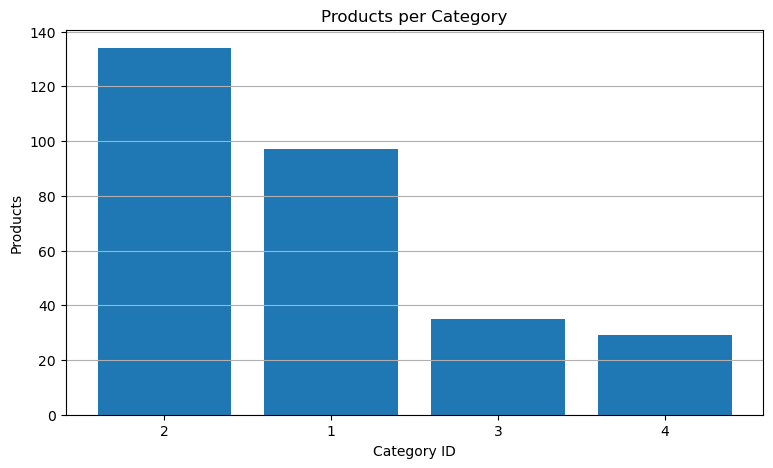

In [6]:
fig, ax = plt.subplots(figsize=(9, 5))

data = { k:v for (k,v) in zip((str(i) for i in products_per_category["ProductCategoryID"]), (len(i) for i in products_per_category["ProductID"]))}  
sorted_data = sort_dict(data)

x = [i for i in sorted_data]
y = [sorted_data[i] for i in sorted_data]

plt.bar(x, y)
plt.title("Products per Category")
plt.xlabel("Category ID")
plt.ylabel("Products")
plt.grid(axis="y")
plt.show()

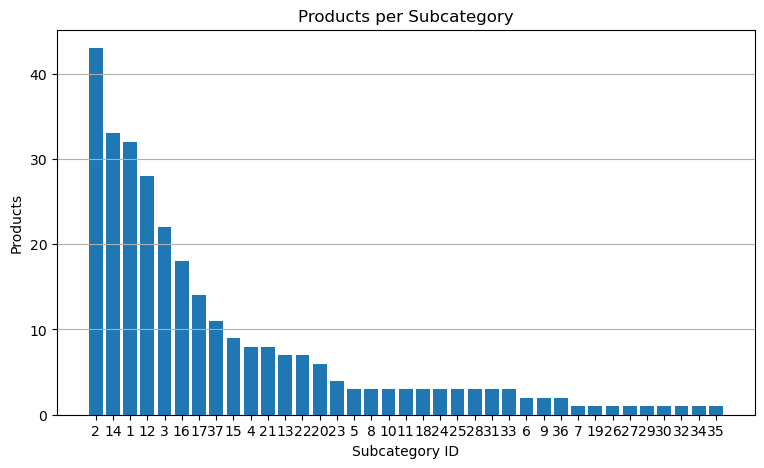

In [7]:
fig, ax = plt.subplots(figsize=(9, 5))

data = { k:v for (k,v) in zip((str(i) for i in categorized_products["ProductSubcategoryID"]), (len(i) for i in categorized_products["ProductID"]))}  
sorted_data = sort_dict(data)

x = [i for i in sorted_data]
y = [sorted_data[i] for i in sorted_data]

plt.bar(x, y)
plt.title("Products per Subcategory")
plt.xlabel("Subcategory ID")
plt.ylabel("Products")
plt.grid(axis="y")
plt.show()

## Conclusion Task 1:
Category 2 has the most products at 134 and Category 4 the least at 29
* Category 2: 134
* Category 1: 97
* Category 3: 35
* Category 4: 29

Subcategory 2 has the most products at 43

# Task 2 - Sales per category

**Goal:** Calculate the sales per ProductCategory and ProductSubcategory.

**Method:**
1. Create query for the OrderQty, ProductID and UnitPrice
2. Create new DataFrame with the query
3. Group and aggregate by ProductID and UnitPrice, summing OrderQty
4. Calculate the revenue for each ProductID by multiplying OrderQty and UnitPrice
5. Group and aggregate by ProductID, summing revenue
6. Group by ProductCategoryID and ProductSubcategoryID, summing the revenues
7. Plot data

### Create DataFrame with OrderQty, ProductID and UnitPrice

In [31]:
sales_query = """
SELECT OrderQty, ProductID, UnitPrice
FROM Sales.SalesOrderDetail
"""

sales_df = query_df(sales_query).sort_values("ProductID").reset_index(drop=True)
sales_df.head()

,OrderQty,ProductID,UnitPrice
0,4,707,20.9940
1,4,707,20.9940
2,1,707,34.9900
3,4,707,20.9940
4,2,707,20.1865


### Sum OrderQty for each unique ProductID + UnitPrice

In [9]:
df_grouped = (
    sales_df
    .groupby(["ProductID", "UnitPrice"], as_index=False)
    .agg({"OrderQty": "sum"})
)

df_grouped

,ProductID,UnitPrice,OrderQty
0,707,15.7455,222
1,707,16.8221,162
2,707,18.5043,56
3,707,19.2445,66
4,707,19.5136,135
...,...,...,...
752,998,323.9940,1062
753,998,539.9900,363
754,999,313.1942,71
755,999,323.9940,881


### Calculate the revenue for each row and add new column for revenue

In [10]:
df_grouped["Revenue"] = df_grouped.UnitPrice * df_grouped.OrderQty

df_grouped

,ProductID,UnitPrice,OrderQty,Revenue
0,707,15.7455,222,3495.5010
1,707,16.8221,162,2725.1802
2,707,18.5043,56,1036.2408
3,707,19.2445,66,1270.1370
4,707,19.5136,135,2634.3360
...,...,...,...,...
752,998,323.9940,1062,344081.6280
753,998,539.9900,363,196016.3700
754,999,313.1942,71,22236.7882
755,999,323.9940,881,285438.7140


### Group by ProductID and sum revenue

In [30]:
df_revenue = (
    df_grouped
    .groupby(["ProductID"], as_index=False)
    .agg({"Revenue": "sum"})
)

df_revenue.head()

,ProductID,Revenue
0,707,158865.9084
1,708,162076.7042
2,709,6147.6400
3,710,513.0000
4,711,166720.9076


### Combine ProductID's to ProductCategoryID and sum revenues

In [12]:
# Category df
df_result = (
    products_per_category
        .explode('ProductID')
        .merge(df_revenue, on='ProductID', how='left')
        .groupby('ProductCategoryID', as_index=False)['Revenue']
        .sum()
)
df_result = df_result.sort_values(by="Revenue", ascending=False).reset_index(drop=True)

# Subcategory df
df_result_sub = (
    categorized_products
        .explode('ProductID')
        .merge(df_revenue, on='ProductID', how='left')
        .groupby('ProductSubcategoryID', as_index=False)['Revenue']
        .sum()
)
df_result_sub = df_result_sub.sort_values(by="Revenue", ascending=False).reset_index(drop=True)

### Graph

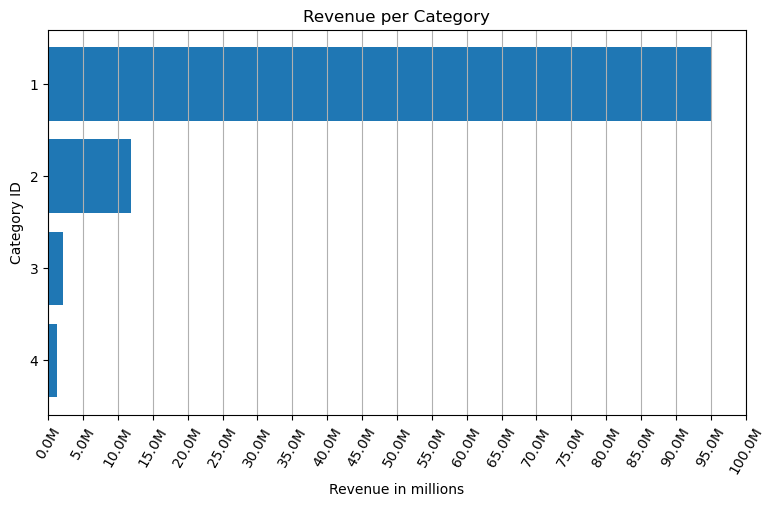

In [13]:
fig, ax = plt.subplots(figsize=(9, 5))

data = { k:v for (k,v) in zip((str(i) for i in df_result["ProductCategoryID"]), (i for i in df_result["Revenue"]))}  
sorted_data = sort_dict(data, False)

x = [i for i in sorted_data]
y = [sorted_data[i] for i in sorted_data]

plt.barh(x, y)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))
tick_pos = range(0, 100000001, 5000000)
plt.xticks(tick_pos, rotation=60)
plt.title("Revenue per Category")
plt.ylabel("Category ID")
plt.xlabel("Revenue in millions")
plt.grid(axis="x")
plt.show()

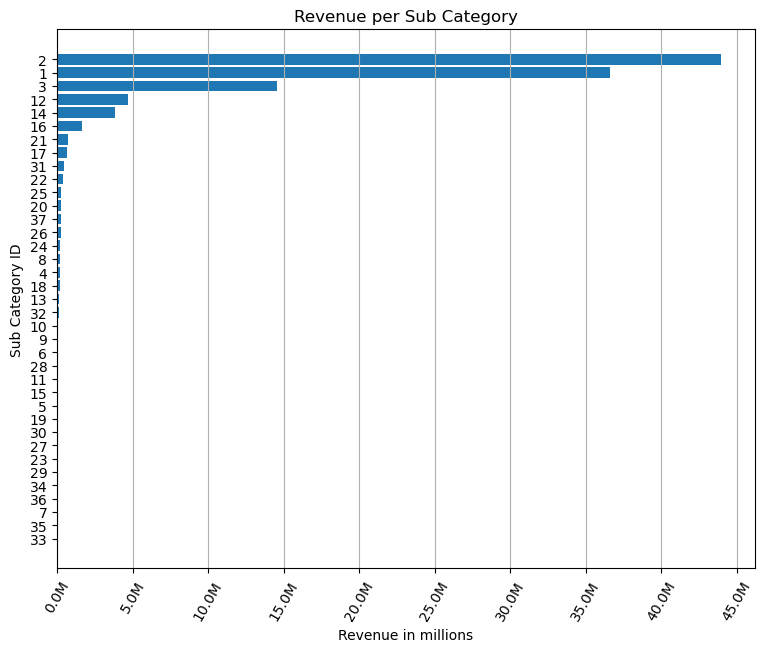

In [14]:
fig, ax = plt.subplots(figsize=(9, 7))

data = { k:v for (k,v) in zip((str(i) for i in df_result_sub["ProductSubcategoryID"]), (i for i in df_result_sub["Revenue"]))}  
sorted_data = sort_dict(data, False)
x = [i for i in sorted_data]
y = [sorted_data[i] for i in sorted_data]

plt.barh(x, y)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))
tick_pos = range(0, 45_000_001, 5_000_000)
plt.xticks(tick_pos, rotation=60)
plt.title("Revenue per Sub Category")
plt.ylabel("Sub Category ID")
plt.xlabel("Revenue in millions")
plt.grid(axis="x")
plt.show()

## Conclusion Task 2
Sub Category 2 has the most revenue at 43,978,443.2489 and Sub Category 33 has the least revenue at 0.0

# Task 3 - Sales trend over time

**Goal:** Show the sales trend over time

**Method:**
1. Create query for the SalesOrderID and OrderDate
2. Create DataFrame with dates as YYYY-MM, group by date and make list of all orders during that month
3. Plot sales over time

### Create dataframe of SalesOrderID and OrderDate

In [29]:
# Specify a query and get dataframe of OrderDates
order_query = """
SELECT SalesOrderID, OrderDate, SubTotal
FROM Sales.SalesOrderHeader
"""

order_df = query_df(order_query)
order_df.head()

,SalesOrderID,OrderDate,SubTotal
0,43659,2022-05-30,20565.6206
1,43660,2022-05-30,1294.2529
2,43661,2022-05-30,32726.4786
3,43662,2022-05-30,28832.5289
4,43663,2022-05-30,419.4589


### Create new DataFrame containing the DateID as YYYY-MM, list of SalesOrderID's that occured that month and SubTotal

In [28]:
order_df["OrderDate"] = pd.to_datetime(order_df["OrderDate"])

monthly_order_df = (
    order_df
    .assign(DateID=order_df["OrderDate"].dt.to_period("M"))
    .groupby("DateID", as_index=False)
    .agg({"SalesOrderID": list, "SubTotal": "sum"})
)

monthly_order_df.head()

,DateID,SalesOrderID,SubTotal
0,2022-05,"[43659, 43660, 43661, 43662, 43663, 43664, 436...",5.177374e+05
1,2022-06,"[43706, 43707, 43708, 43709, 43710, 43711, 437...",2.001279e+06
2,2022-07,"[43923, 43924, 43925, 43926, 43927, 43928, 439...",1.668510e+06
3,2022-08,"[44138, 44139, 44140, 44141, 44142, 44143, 441...",1.326138e+06
4,2022-09,"[44327, 44328, 44329, 44330, 44331, 44332, 443...",2.836410e+06


### Graph

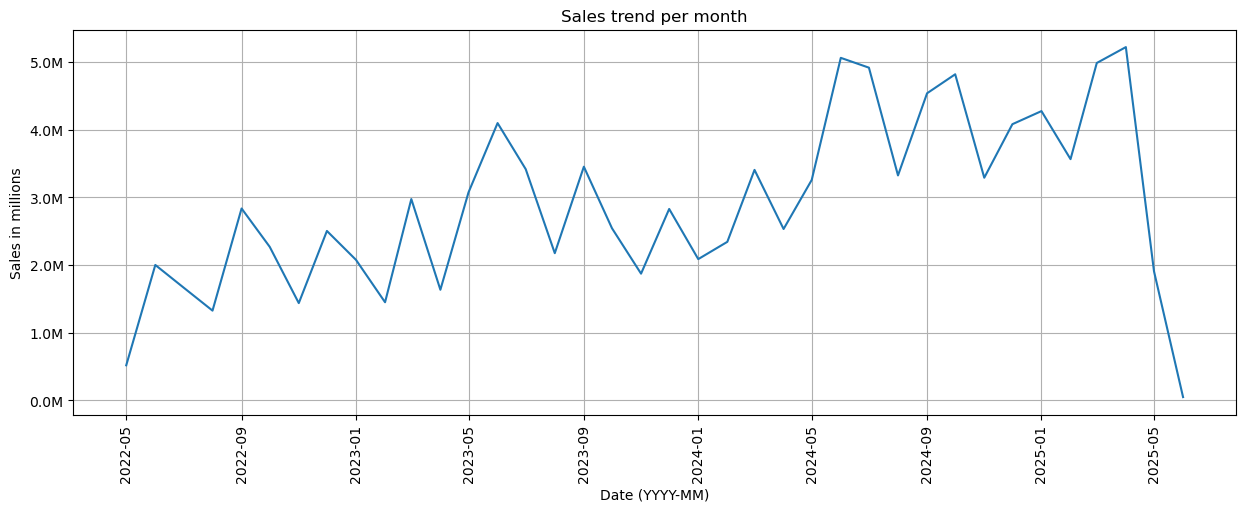

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))

data = { k:v for (k,v) in zip((str(i) for i in monthly_order_df["DateID"]), (i for i in monthly_order_df["SubTotal"]))}

x = [datetime.datetime.strptime(i, "%Y-%m") for i in data]
y = [data[i] for i in data]

plt.plot(x, y, linestyle="solid")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.xticks(rotation=90)
plt.title("Sales trend per month")
plt.ylabel("Sales in millions")
plt.xlabel("Date (YYYY-MM)")
plt.grid()
plt.show()

## Conclusion Task 3
The sales appear to be somewhat seasonally dependent.
* The sales generally increase around February, April, August, November
* The sales generally decrease around March, June, September, December
The month with the most sales is April 2025 and the month with the least sales is July 2022. Ignoring the endpoints as the data may be incomplete.

# Task 4 - Sales and number of orders per year

**Goal:** Show the sales and order count per year as grouped bar plot

**Method:**
1. Create DataFrame with dates as YYYY, group by date and sum the SubTotal
2. Plot sales and order count as grouped bar plot

### Create DataFrame of TotalOrders and SubTotal grouped by year

In [18]:
order_df["OrderDate"] = pd.to_datetime(order_df["OrderDate"])

yearly_order_df = (
    order_df
    .assign(DateID=order_df["OrderDate"].dt.to_period("Y"))
    .groupby("DateID", as_index=False)
    .agg({"SalesOrderID": list, "SubTotal": "sum"})
)

yearly_order_df["SalesOrderID"] = yearly_order_df["SalesOrderID"].str.len().astype(int)
yearly_order_df = yearly_order_df.rename(columns={"SalesOrderID": "TotalOrders"})
yearly_order_df

,DateID,TotalOrders,SubTotal
0,2022,1692,1.456105e+07
1,2023,3830,3.160492e+07
2,2024,14244,4.367189e+07
3,2025,11699,2.000852e+07


### Graph

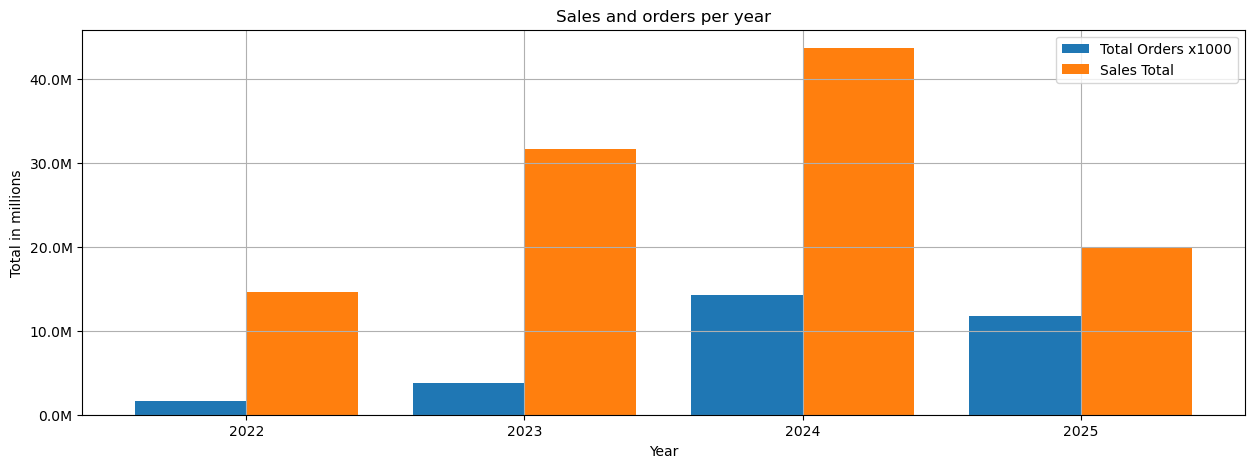

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))

data = { k:v for (k,v) in zip((str(i) for i in yearly_order_df["DateID"]), (i for i in monthly_order_df["SubTotal"]))}

temp = [int(i) for i in data]
x = np.arange(min(temp), max(temp)+1, 1)
y1 = [i*1000 for i in yearly_order_df["TotalOrders"]]
y2 = [i for i in yearly_order_df["SubTotal"]]
w = 0.4

ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.bar(x-0.2, y1, w)
plt.bar(x+0.2, y2, w)
plt.title("Sales and orders per year")
plt.ylabel("Total in millions")
plt.xlabel("Year")
plt.legend(["Total Orders x1000", "Sales Total"])
plt.grid()
plt.show()

## Conclusion Task 4
Year 2024 had the most sales and the most orders. Year 2022 had the least sales and the least orders.
Sales and number of orders appears to be related. More orders results in more sales which can be expected in general. It is not a guarantee as the case where there are a lot of orders but all orders have little sales value would show otherwise.
* **Year 2024** had the most sales and the most orders.
* **Year 2022** had the least sales and the least orders.

# Task 5 - Top 10 Products

**Goal:** Show top 10 products and subcategories

**Method:**
1. Create TOP 10 query for ProductID and SUM(OrderQty * UnitPrice) AS TotalRevenue
2. Create DataFrame
3. Plot TOP 10 products
4. Bonus plot showing TOP 10 subcategories

### Create DataFrame of the top 10 products

In [20]:
# Specify a query to get the top 10 products. TotalRevenue is OrderQty * UnitPrice, group id by ProductID and sort in DESCENDING order
top10_query = """
SELECT TOP 10
    ProductID,
    SUM(OrderQty * UnitPrice) AS TotalRevenue
FROM Sales.SalesOrderDetail
GROUP BY ProductID
ORDER BY TotalRevenue DESC
"""

top10_df = query_df(top10_query)
top10_df

,ProductID,TotalRevenue
0,782,4.406151e+06
1,783,4.014068e+06
2,779,3.696486e+06
3,780,3.441293e+06
4,781,3.436091e+06
5,784,3.311098e+06
6,793,2.518300e+06
7,794,2.348246e+06
8,795,2.012448e+06
9,753,1.847819e+06


### Graph

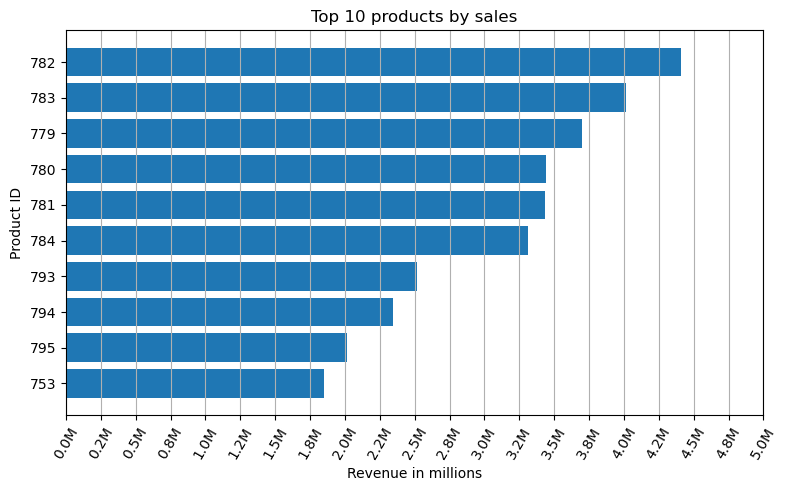

In [21]:
fig, ax = plt.subplots(figsize=(9, 5))

data = { k:v for (k,v) in zip((str(i) for i in top10_df["ProductID"]), (i for i in top10_df["TotalRevenue"]))}  
sorted_data = sort_dict(data, False)

x = [i for i in sorted_data]
y = [sorted_data[i] for i in sorted_data]

plt.barh(x, y)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))
tick_pos = range(0, 5_000_001, 250_000)
plt.xticks(tick_pos, rotation=60)
plt.title("Top 10 products by sales")
plt.ylabel("Product ID")
plt.xlabel("Revenue in millions")
plt.grid(axis="x")
plt.show()

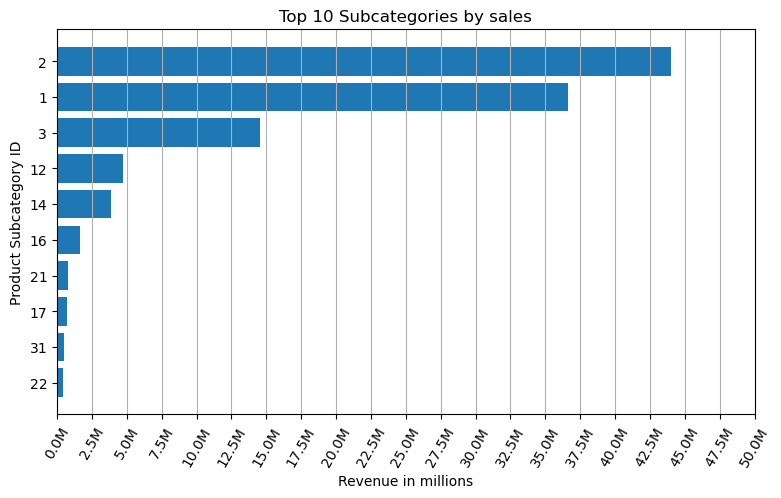

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))

data = { k:v for (k,v) in zip((str(i) for i in df_result_sub.head(10)["ProductSubcategoryID"]), (i for i in df_result_sub.head(10)["Revenue"]))}  
sorted_data = sort_dict(data, False)

x = [i for i in sorted_data]
y = [sorted_data[i] for i in sorted_data]

plt.barh(x, y)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))
tick_pos = range(0, 50_000_001, 2_500_000)
plt.xticks(tick_pos, rotation=60)
plt.title("Top 10 Subcategories by sales")
plt.ylabel("Product Subcategory ID")
plt.xlabel("Revenue in millions")
plt.grid(axis="x")
plt.show()

## Conclusion Task 5
Product 782 dominates the top 10 list at 4,406,151.2662 whereas Subcategory 2 dominates the top 10 list at 43,978,443.2489

# Task 6 - Sales and number of customers per region

**Goal:** Show sales and the number of customers per region

**Method:**
1. Create query for SalesOrderID, SalesPersonID, CustomerID, TerritoryID, SubTotal
2. Create DataFrame containing all sales. Fill NaN with -1 to symbolize individual order
3. Group by TerritoryID and sum the SubTotal
4. Plot data

### Create DataFrame of SalesOrderID, CustomerID, TerritoryID and SubTotal

In [23]:
sales_query = """
SELECT SalesOrderID, SalesPersonID, CustomerID, TerritoryID, SubTotal
FROM Sales.SalesOrderHeader
"""

all_sales = query_df(sales_query)
all_sales = all_sales.fillna(-1)

all_sales

,SalesOrderID,SalesPersonID,CustomerID,TerritoryID,SubTotal
0,43659,279.0,29825,5,20565.6206
1,43660,279.0,29672,5,1294.2529
2,43661,282.0,29734,6,32726.4786
3,43662,282.0,29994,6,28832.5289
4,43663,276.0,29565,4,419.4589
...,...,...,...,...,...
31460,75119,-1.0,11981,1,42.2800
31461,75120,-1.0,18749,6,84.9600
31462,75121,-1.0,15251,6,74.9800
31463,75122,-1.0,15868,6,30.9700


### Group by CustomerID and make new column containing all SalesOrderID's in a list

In [24]:
# Group by TerritoryID and get length of list of customers and SubTotal
all_sales_territory = (
    all_sales
    .groupby("TerritoryID", as_index=False)
    .agg({"TerritoryID": "first", "CustomerID": len, "SubTotal": "sum"})
)
all_sales_territory.rename(columns={"CustomerID": "CustomerCount"}, inplace=True)
all_sales_territory = all_sales_territory.sort_values(by="SubTotal", ascending=False).reset_index(drop=True)
all_sales_territory["AverageOrderValue"] = all_sales_territory["SubTotal"] / all_sales_territory["CustomerCount"]

all_sales_territory

,TerritoryID,CustomerCount,SubTotal,AverageOrderValue
0,4,6224,2.418461e+07,3885.702057
1,6,4067,1.635577e+07,4021.581130
2,1,4594,1.608494e+07,3501.293546
3,9,6843,1.065534e+07,1557.114710
4,3,385,7.909009e+06,20542.880536
5,5,486,7.879655e+06,16213.282043
6,10,3219,7.670721e+06,2382.951549
7,7,2672,7.251556e+06,2713.905557
8,2,352,6.939374e+06,19714.132049
9,8,2623,4.915408e+06,1873.964009


### Graph

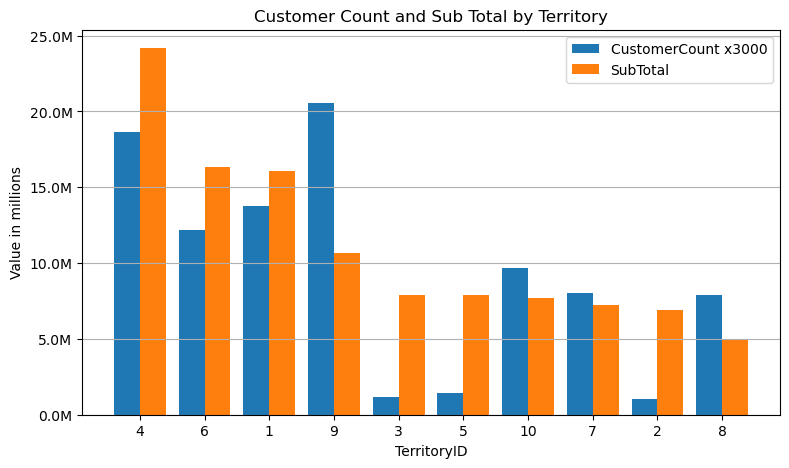

In [25]:
x = np.arange(len(all_sales_territory))
width = 0.4

fig, ax = plt.subplots(figsize=(9, 5))

ax.bar(x - width/2, all_sales_territory["CustomerCount"]*3000, width, label="CustomerCount x3000")
ax.bar(x + width/2, all_sales_territory["SubTotal"], width, label="SubTotal")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))
ax.set_xticks(x, all_sales_territory["TerritoryID"])
ax.set_xlabel("TerritoryID")
ax.set_ylabel("Value in millions")
ax.set_title("Customer Count and Sub Total by Territory")
ax.grid(axis="y")
ax.legend()

plt.show()

## Conclusion Task 6
Territory 4 (Southwest, North America) has the most sales and the most customers.
Territory 2, 3, 5 are peculiar. They have the highest sales per customer.

# Task 7 - Average order value per region and customer type

**Goal:** Show average sales for each customer type (Individual and store) per region

**Method:**
1. Create two new DataFrames. One where SalesPersonID is less than 0 (Individual order) and one for greater than 0 (Store order)
2. Calculate average sales per group
3. Plot both groups as grouped bar plot

### Filter all_sales DataFrame into two seperate, one for individual orders and one for store orders

In [26]:
# Individual orders has no sales person, NaN replaced with -1 symbolizes no sales person, therefore an individual order.
indiv_sales = all_sales.loc[all_sales["SalesPersonID"] < 0]
# Group by TerritoryID and get length of list of customers and SubTotal
indiv_sales_territory = (
    indiv_sales
    .groupby("TerritoryID", as_index=False)
    .agg({"TerritoryID": "first", "CustomerID": len, "SubTotal": "sum"})
)
indiv_sales_territory.rename(columns={"CustomerID": "OrderCount"}, inplace=True)
indiv_sales_territory["AverageOrderValue"] = indiv_sales_territory["SubTotal"] / indiv_sales_territory["OrderCount"]
indiv_sales_territory = indiv_sales_territory.sort_values(by="AverageOrderValue", ascending=False).reset_index(drop=True)

store_sales = all_sales.loc[all_sales["SalesPersonID"] > 0]
# Group by TerritoryID and get length of list of customers and SubTotal
store_sales_territory = (
    store_sales
    .groupby("TerritoryID", as_index=False)
    .agg({"TerritoryID": "first", "CustomerID": len, "SubTotal": "sum"})
)
store_sales_territory.rename(columns={"CustomerID": "OrderCount"}, inplace=True)
store_sales_territory["AverageOrderValue"] = store_sales_territory["SubTotal"] / store_sales_territory["OrderCount"]
store_sales_territory = store_sales_territory.sort_values(by="AverageOrderValue", ascending=False).reset_index(drop=True)

store_sales_territory

,TerritoryID,OrderCount,SubTotal,AverageOrderValue
0,4,751,1.846646e+07,24589.159506
1,7,188,4.607538e+06,24508.180495
2,1,536,1.243508e+07,23199.768651
3,10,188,4.279009e+06,22760.685238
4,3,376,7.906008e+06,21026.617491
5,6,692,1.437793e+07,20777.349123
6,2,342,6.932842e+06,20271.467875
7,5,469,7.867416e+06,16774.874677
8,8,139,2.021095e+06,14540.253653
9,9,125,1.594335e+06,12754.683003


### Graph

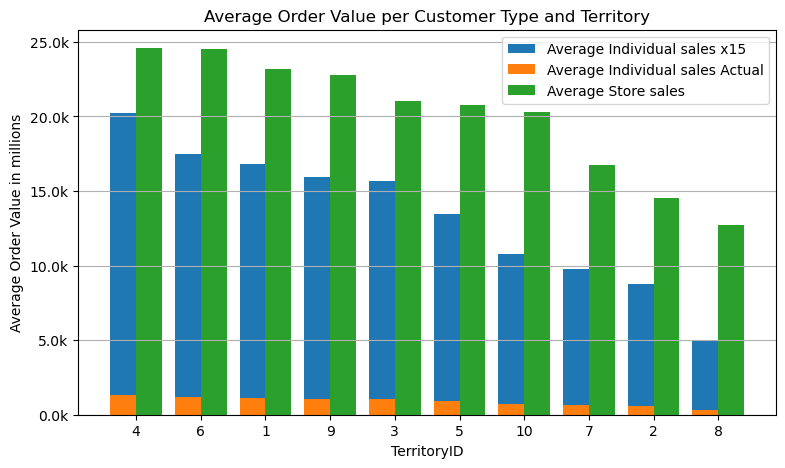

In [27]:
# x1 - indiv_sales_territory
# x2 - store_sales_territory

x = np.arange(len(all_sales_territory))
width = 0.4

fig, ax = plt.subplots(figsize=(9, 5))

ax.bar(x - width/2, indiv_sales_territory["AverageOrderValue"]*15, width, label="Average Individual sales x15")
ax.bar(x - width/2, indiv_sales_territory["AverageOrderValue"], width, label="Average Individual sales Actual")
ax.bar(x + width/2, store_sales_territory["AverageOrderValue"], width, label="Average Store sales")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(thousands))
ax.set_xticks(x, all_sales_territory["TerritoryID"])
ax.set_xlabel("TerritoryID")
ax.set_ylabel("Average Order Value in millions")
ax.set_title("Average Order Value per Customer Type and Territory")
ax.grid(axis="y")
ax.legend()

plt.show()

## Conclusion Task 7
The store has the largest average order value. This can be expected as they generally have more capital and require more products compared to an individual.
Territory 4 (Southwest, North America) has the highest store average order value and highest individual average order value